In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# white and red wine datasets
white_wine_data = pd.read_csv('C:/Users/jasmi/Projects/Wine-Wizardry/wine-quality White.csv')
red_wine_data = pd.read_csv('C:/Users/jasmi/Projects/Wine-Wizardry/wine-quality Red.csv')

# Display first few rows 
white_wine_data.head(), red_wine_data.head()

(   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0            7.0              0.27         0.36            20.7      0.045   
 1            6.3              0.30         0.34             1.6      0.049   
 2            8.1              0.28         0.40             6.9      0.050   
 3            7.2              0.23         0.32             8.5      0.058   
 4            7.2              0.23         0.32             8.5      0.058   
 
    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 0                 45.0                 170.0   1.0010  3.00       0.45   
 1                 14.0                 132.0   0.9940  3.30       0.49   
 2                 30.0                  97.0   0.9951  3.26       0.44   
 3                 47.0                 186.0   0.9956  3.19       0.40   
 4                 47.0                 186.0   0.9956  3.19       0.40   
 
    alcohol  quality  
 0      8.8        6  
 1      9.5        6  
 2 

In [4]:
# Add 'wine_type' to distinguish between red and white
# white_wine_data['wine_type'] = 1
# red_wine_data['wine_type'] = 0

wine_data = pd.concat([white_wine_data, red_wine_data], axis=0)

X = wine_data.drop(columns=['quality'])
y = wine_data['quality']


In [5]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y_adjusted, test_size=0.2, random_state=42)

In [6]:
# the scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
pca = PCA(n_components=9)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
pca_components_df = pd.DataFrame(pca.components_, columns=X.columns)
print(pca.explained_variance_ratio_)
print(X_train_pca.shape)
print(pca_components_df)

[0.27586851 0.22554053 0.14155008 0.08725274 0.06559504 0.0557236
 0.04782159 0.04610138 0.03089119]
(5197, 9)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.240750         -0.379814     0.146599        0.342109  -0.296253   
1       0.336224          0.111470     0.183623        0.333256   0.308801   
2       0.435583         -0.316054     0.589926       -0.171779  -0.030450   
3      -0.151524         -0.216099     0.278502       -0.159152   0.219416   
4       0.140404         -0.129285     0.131817        0.376830  -0.621414   
5       0.200719          0.468269    -0.249313        0.216347  -0.147364   
6      -0.206077         -0.418129    -0.424750        0.078802  -0.134330   
7      -0.449165         -0.002425     0.206066        0.550681   0.464736   
8       0.347152         -0.508538    -0.405466        0.106936   0.300818   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.430251       

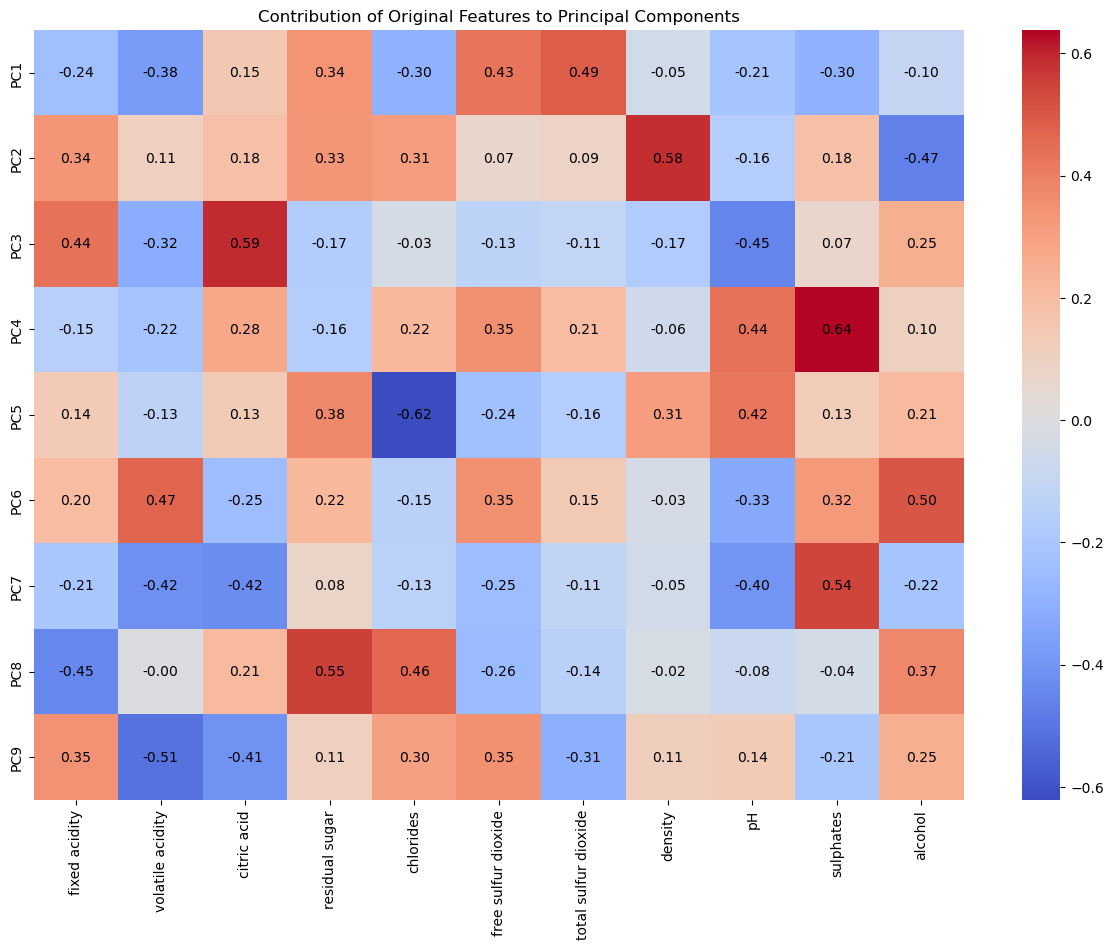

In [8]:
# Manually add annotations for each cell
plt.figure(figsize=(15, 10))
ax = sns.heatmap(pca_components_df, annot=False, fmt=".2f", cmap='coolwarm', xticklabels=X.columns, yticklabels=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])

# Manually add annotations using plt.text
for i in range(pca_components_df.shape[0]):
    for j in range(pca_components_df.shape[1]):
        plt.text(j+0.5, i+0.5, f'{pca_components_df.values[i,j]:.2f}', ha='center', va='center', color='black')

plt.title('Contribution of Original Features to Principal Components')
plt.show()

In [9]:
# Apply SMOTE for class imbalance in combined dataset
smote = SMOTE(random_state=42, k_neighbors=3)  # Set k_neighbors to a lower value
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

In [10]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [11]:


# # train random forest
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
# rf_model.fit(X_train_pca, y_train)

# predict
y_pred = best_rf_model.predict(X_test_pca)
# y_pred = rf_model.predict(X_test_pca)

In [12]:
# accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
accuracy

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.17      0.30        46
           5       0.74      0.74      0.74       420
           6       0.66      0.81      0.72       579
           7       0.73      0.48      0.58       221
           8       0.80      0.25      0.38        32

    accuracy                           0.69      1300
   macro avg       0.65      0.41      0.45      1300
weighted avg       0.71      0.69      0.68      1300



0.6946153846153846

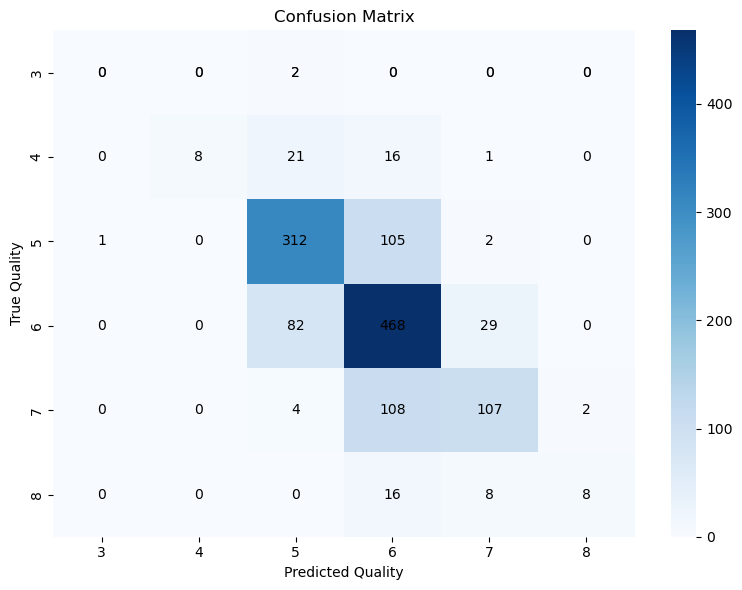

In [13]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[3, 4, 5, 6, 7, 8], yticklabels=[3, 4, 5, 6, 7, 8])
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Quality')
ax.set_ylabel('True Quality')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha='center', va='center', color='black')
plt.tight_layout()
plt.show()